# PRÁCTICA 1

## Imports

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import leidenalg
import igraph as ig
from pyvis.network import Network
import pandas as pd
from IPython.display import display, IFrame

In [2]:
def str_color(r, g, b, a):
    return "#" + format(int(r * 255), f'0{2}x') + format(int(g * 255), f'0{2}x') + format(int(b * 255), f'0{2}x') + format(int(a * 255), f'0{2}x')

def assign_colors(values, vmin=None, vmax=None, cmap=None):
    colormap = plt.cm.magma if cmap is None else cmap

    # Normalizar los valores
    if vmin is None:
        vmin = min(values)
    if vmax is None:
        vmax = max(values)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # Mapear valores a colores
    return [str_color(*colormap(norm(value))) for value in values]

def visualizar_grafo_interactivo(graph, metric_values, nombre_metrica, filename, seed=42):
    """
    Genera un archivo HTML con la visualización del grafo interactivo usando Pyvis.

    Parameters:
    - graph: Grafo de NetworkX.
    - metric_values: Diccionario con los valores calculados para la métrica.
    - nombre_metrica: Nombre de la métrica (e.g., 'Degree Centrality').
    - filename: Nombre del archivo HTML para guardar el grafo.
    - seed: Semilla para el cálculo del layout (para reproducibilidad).
    """
    # Asignar atributos al grafo
    nx.set_node_attributes(graph, {n: f"{v:.4f}" for n, v in metric_values.items()}, 'title')
    nx.set_node_attributes(graph, {n: v for n, v in zip(metric_values.keys(), assign_colors(metric_values.values()))}, 'color')
    nx.set_node_attributes(graph, {n: f"{n}" for n in graph.nodes}, 'label')
    nx.set_node_attributes(graph, "dot", 'shape')

    # Calcular posiciones usando Spring Layout
    pos = nx.spring_layout(graph, seed=seed, k=12)

    # Crear el grafo interactivo con Pyvis
    net = Network(notebook=True, height='500px', width='100%', bgcolor="#DCDCDC")

    # Agregar nodos con posiciones calculadas y colores únicos
    for i, (node, (x, y)) in enumerate(pos.items()):
        net.add_node(
            n_id=node,
            label=str(node),  # Etiqueta del nodo
            title=f"{nombre_metrica}: {metric_values[node]:.4f}",  # Valor de la métrica al pasar el ratón
            color=graph.nodes[node].get('color', ''),  # Color del nodo basado en atributos
            x=x * 1000,  # Escalar posiciones para Pyvis
            y=y * 1000
        )

    # Agregar aristas
    for edge in graph.edges():
        net.add_edge(edge[0], edge[1])

    # Desactivar física para mantener el layout fijo
    net.set_options('''
    var options = {
      "physics": {
        "enabled": false
      }
    }
    ''')

    # Mostrar el grafo interactivo
    net.show(filename)
    display(IFrame(src=filename, width="100%", height="600px"))


## Carga del grafo

In [3]:
G = nx.read_graphml("./data/hashtags_cleaned/hashtags_cleaned.graphml")
print("INFORMACIÓN DEL GRAFO:")
print(f"Numero de nodos: {G.number_of_nodes()}")
print(f"Numero de aristas: {G.number_of_edges()}")

INFORMACIÓN DEL GRAFO:
Numero de nodos: 47544
Numero de aristas: 536124


Como el grafo es bastante grande no podemos realizar una visualización completa de este.

## Ejercicio 1

Calcula las comunidades, utilizándo el algoritmo de Leiden. ¿Cuantas comunidades salen?

Número de comunidades detectadas: 38
Comunidad 0: 9935 nodos
Comunidad 1: 6703 nodos
Comunidad 2: 6213 nodos
Comunidad 3: 5824 nodos
Comunidad 4: 5131 nodos
Comunidad 5: 4800 nodos
Comunidad 6: 2244 nodos
Comunidad 7: 1817 nodos
Comunidad 8: 1617 nodos
Comunidad 9: 1138 nodos
Comunidad 10: 877 nodos
Comunidad 11: 296 nodos
Comunidad 12: 250 nodos
Comunidad 13: 203 nodos
Comunidad 14: 115 nodos
Comunidad 15: 74 nodos
Comunidad 16: 64 nodos
Comunidad 17: 45 nodos
Comunidad 18: 19 nodos
Comunidad 19: 18 nodos
Comunidad 20: 18 nodos
Comunidad 21: 17 nodos
Comunidad 22: 17 nodos
Comunidad 23: 16 nodos
Comunidad 24: 15 nodos
Comunidad 25: 10 nodos
Comunidad 26: 9 nodos
Comunidad 27: 8 nodos
Comunidad 28: 7 nodos
Comunidad 29: 6 nodos
Comunidad 30: 6 nodos
Comunidad 31: 6 nodos
Comunidad 32: 5 nodos
Comunidad 33: 5 nodos
Comunidad 34: 4 nodos
Comunidad 35: 4 nodos
Comunidad 36: 4 nodos
Comunidad 37: 4 nodos


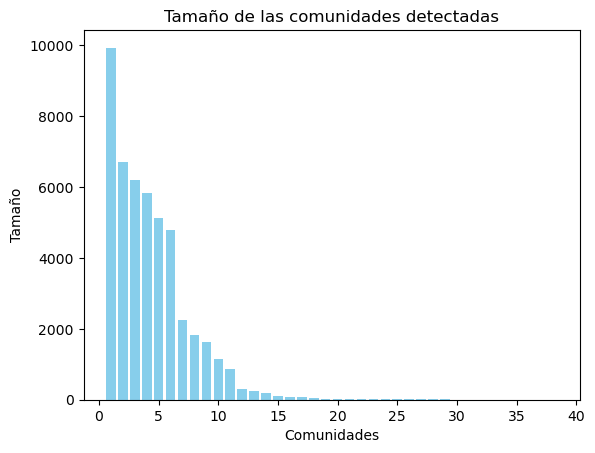

In [4]:
# Convertir el grafo de NetworkX a igraph
G_ig = ig.Graph.TupleList(G.edges(), directed=False)

# Ejecutar el algoritmo de Leiden para detectar comunidades
partition = leidenalg.find_partition(G_ig, leidenalg.ModularityVertexPartition, seed=10)

# Número de comunidades detectadas
num_comunidades = len(partition)
print(f"Número de comunidades detectadas: {num_comunidades}")

# Mostrar el número de nodos en cada comunidad
comunidad_sizes = [len(comunidad) for comunidad in partition]
for i, size in enumerate(comunidad_sizes):
    print(f"Comunidad {i}: {size} nodos")

# Gráfica del tamaño de las comunidades
plt.bar(range(1, num_comunidades+1), comunidad_sizes, color='skyblue')
plt.xlabel('Comunidades')
plt.ylabel('Tamaño')
plt.title('Tamaño de las comunidades detectadas')
plt.show()

## Ejercicio 2

Colapsa el grafo de forma que cada nodo sea una comunidad, manteniendo los atributos.

In [5]:
# Creamos un diccionario que relaciona los nodos a las comunidades
node_to_community = {}
for community_index, community in enumerate(partition):
    for node in community:
        node_to_community[list(G.nodes())[node]] = community_index

# Organizar nodos por comunidad
nodos_por_comunidad = {}
for nodo, comunidad in node_to_community.items():
    if comunidad not in nodos_por_comunidad:
        nodos_por_comunidad[comunidad] = []
    nodos_por_comunidad[comunidad].append(nodo)

# Mostrar 5 nodos por comunidad
print("Nodos por comunidad:")
for comunidad, nodos in nodos_por_comunidad.items():
    print(f"Comunidad {comunidad}: {nodos[:5]} (Total: {len(nodos)} nodos)")


Nodos por comunidad:
Comunidad 0: ['Chine', 'James', 'birdphotography', 'forex_fx', 'eurusd'] (Total: 9935 nodos)
Comunidad 1: ['tgdn', 'FOX', 'LoveIsLove', 'JMandJane2020', 'marvel'] (Total: 6703 nodos)
Comunidad 2: ['OMS', 'lockdown', 'Beijing', 'SmellDog', 'Hoax'] (Total: 6213 nodos)
Comunidad 3: ['Υστερογραφα', 'Stimulus', 'WaterIsland', 'FringeLeftists', 'Epsteindidntkillhimself'] (Total: 5824 nodos)
Comunidad 4: ['usdjpy', 'International', 'nosjournaal', 'Cougars', 'hope'] (Total: 5131 nodos)
Comunidad 5: ['abd', 'Inauguration', 'Brooklyn', 'AR2', 'AR3'] (Total: 4800 nodos)
Comunidad 6: ['birds', 'naturelovers', 'forex', 'orbex_fx', 'analiz'] (Total: 2244 nodos)
Comunidad 7: ['RememberinNovember', 'Noticias', 'Clippers', 'Traitor', 'ronjohnson'] (Total: 1817 nodos)
Comunidad 8: ['Jinek', 'shopijam', 'icantbreathe', 'NeverGiveUp', 'Covid19UK'] (Total: 1617 nodos)
Comunidad 9: ['C19', 'compassion', 'Emmys', 'AZpol', 'IApolitics'] (Total: 1138 nodos)
Comunidad 10: ['mediabias', 'All

In [6]:
# Crear un nuevo grafo colapsado
collapsed_graph = nx.Graph()

# Agregar un nodo para cada comunidad
for community_index in range(len(partition)):
    collapsed_graph.add_node(community_index, size=len(partition[community_index]))  # Tamaño de la comunidad

# Agregar aristas entre comunidades
for edge in G.edges(data=True):
    # Verificar que ambos nodos estén asignados a una comunidad
    if edge[0] in node_to_community and edge[1] in node_to_community:
        comunidad_u = node_to_community[edge[0]]
        comunidad_v = node_to_community[edge[1]]

        # Si son diferentes, añadimos o incrementamos el peso de la arista entre comunidades
        if comunidad_u != comunidad_v:
            if collapsed_graph.has_edge(comunidad_u, comunidad_v):
                collapsed_graph[comunidad_u][comunidad_v]["weight"] += 1
            else:
                collapsed_graph.add_edge(comunidad_u, comunidad_v, weight=1)

print("INFORMACIÓN DEL GRAFO COLAPSADO:")
print(f"Numero de nodos: {collapsed_graph.number_of_nodes()}")
print(f"Numero de aristas: {collapsed_graph.number_of_edges()}")

INFORMACIÓN DEL GRAFO COLAPSADO:
Numero de nodos: 38
Numero de aristas: 353


Vamos a representar visualmente el grafo colapsado. En esta representación, el tamaño de un nodo n representará el tamaño de la comunidad; y las aristas tendrán un ancho proporcional al número de conexiones entre esas dos comunidades relativo al número de nodos totales de ambas comunidades.

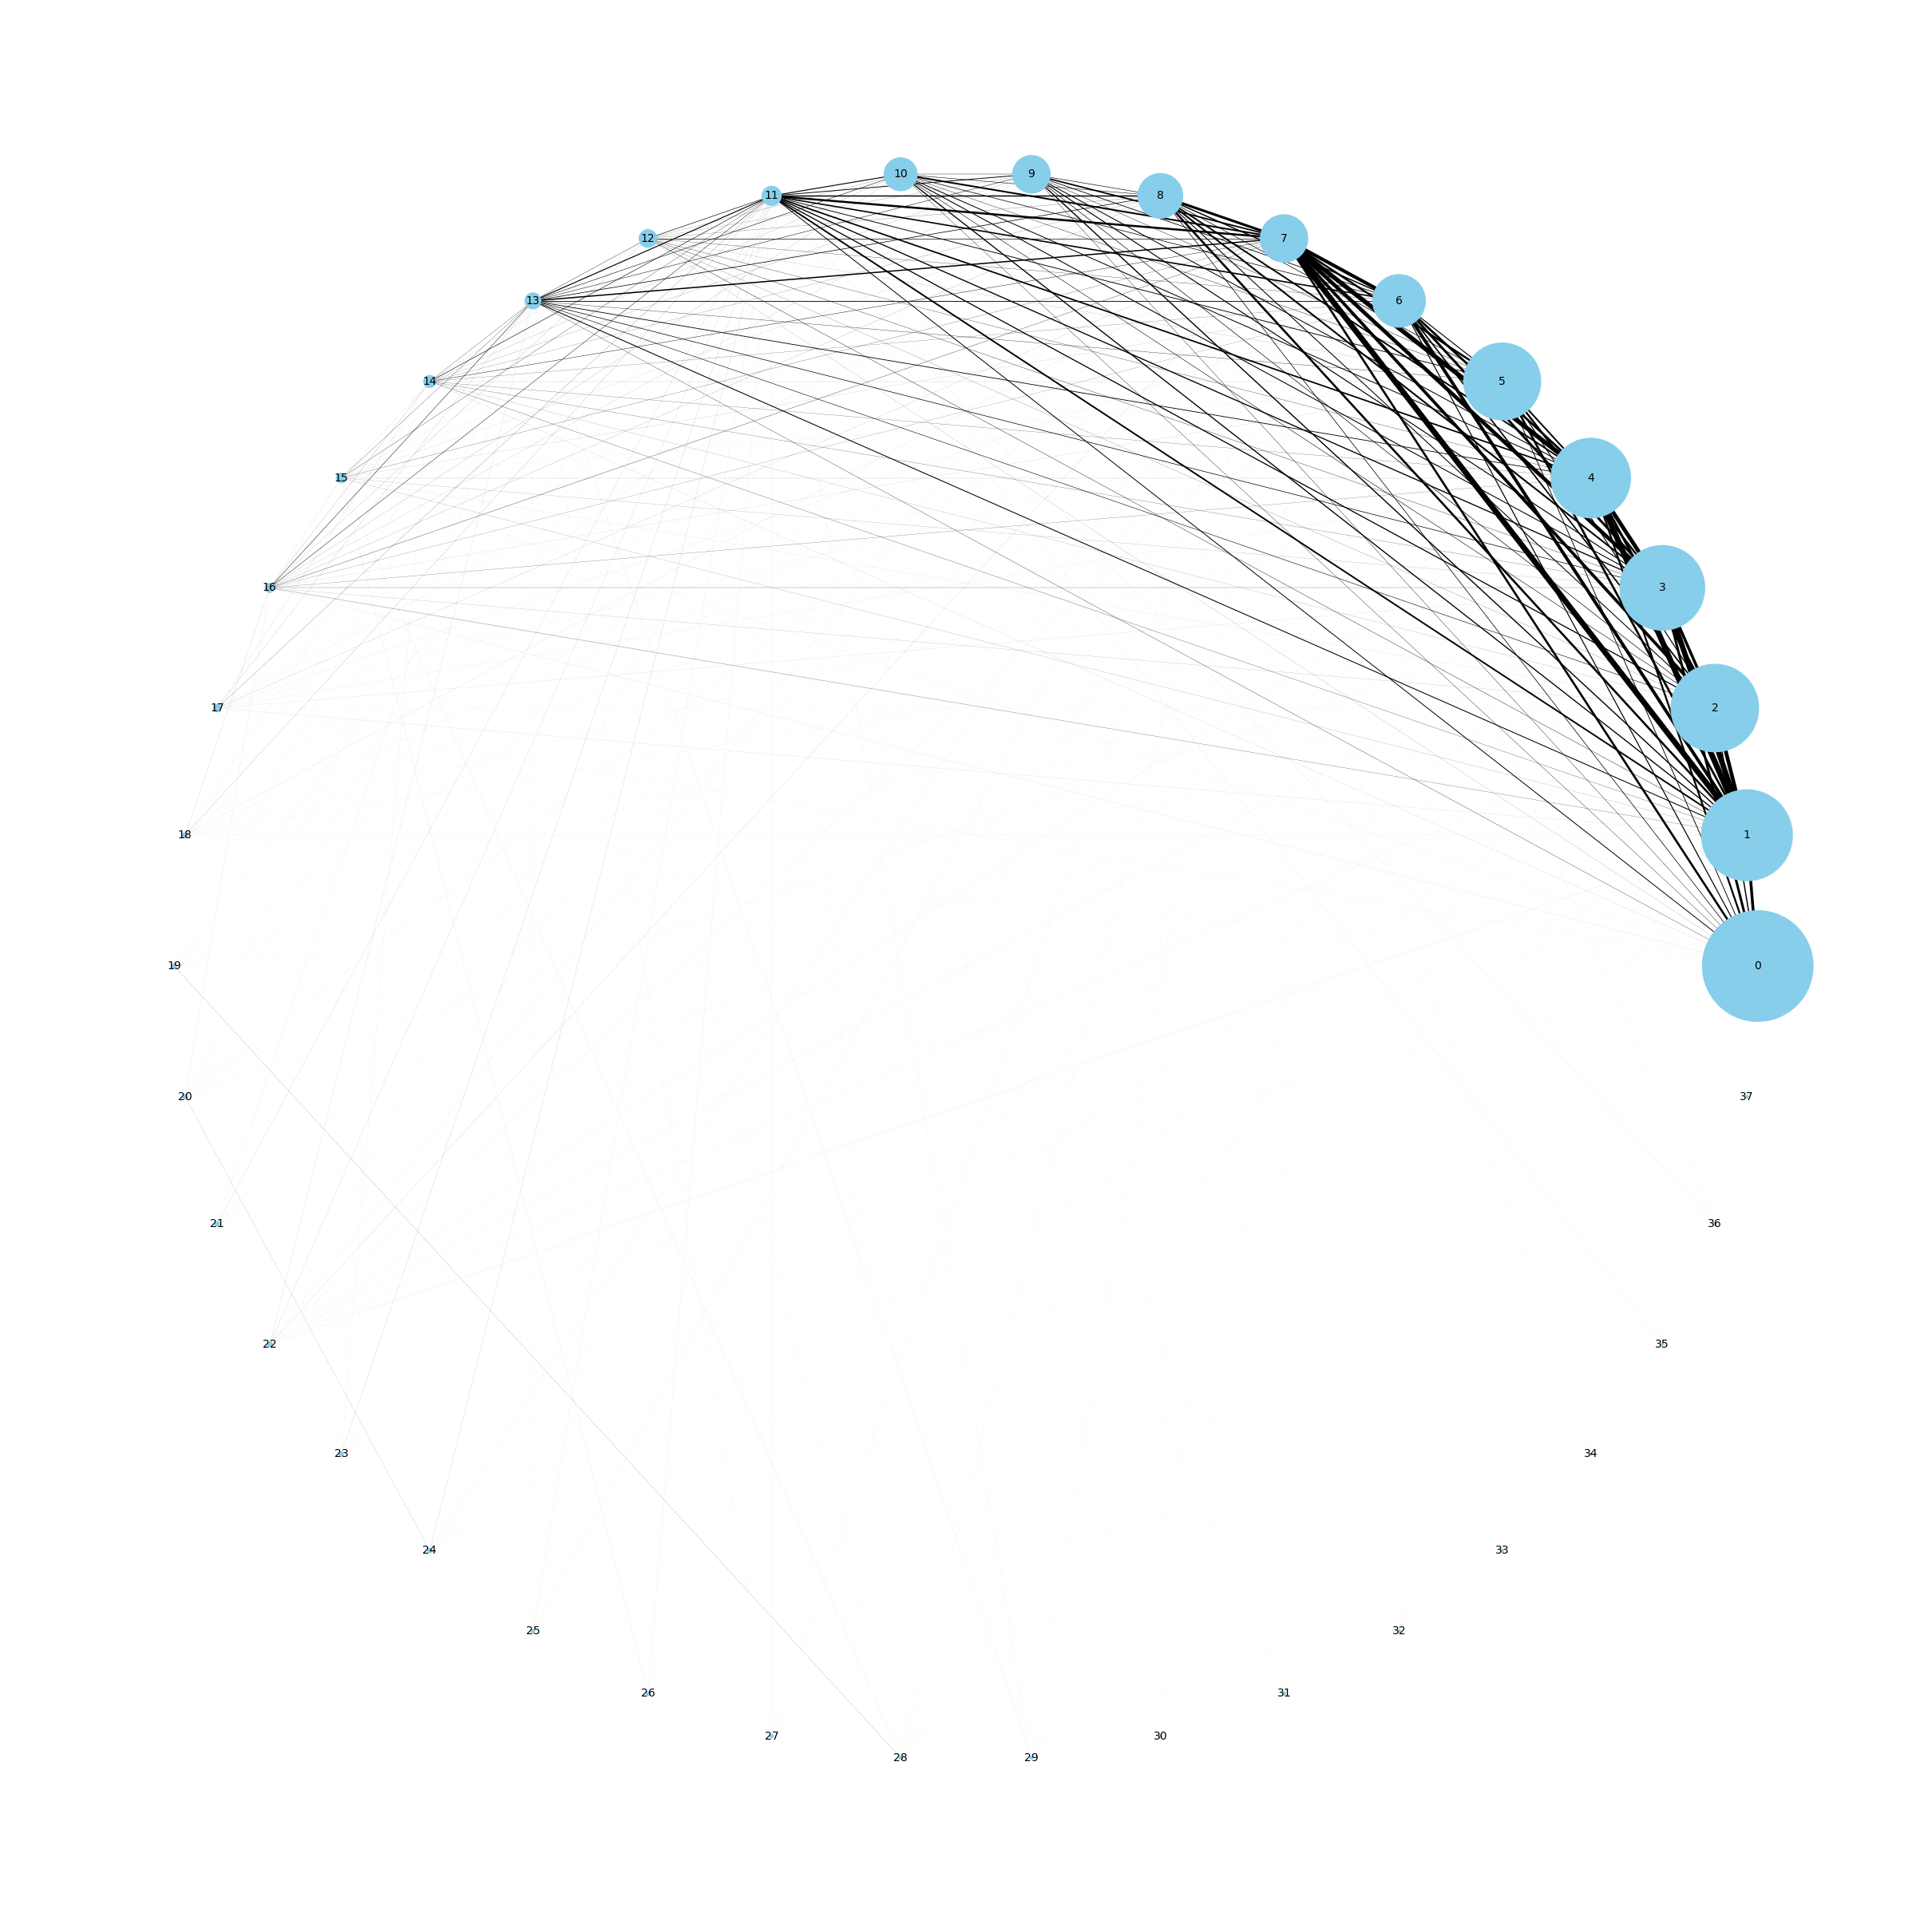

In [7]:
node_sizes = [collapsed_graph.nodes[node]["size"] for node in collapsed_graph.nodes]
edge_weights = [2 * collapsed_graph[u][v]["weight"] / (collapsed_graph.nodes[u]["size"] + collapsed_graph.nodes[v]["size"]) for u, v in collapsed_graph.edges]

# Configurar el layout circular
pos = nx.circular_layout(collapsed_graph)

# Crear el gráfico
plt.figure(figsize=(24, 24))

nx.draw(
    collapsed_graph,
    pos=pos,  # Usar layout circular
    with_labels=True,
    node_size=node_sizes,
    width=edge_weights,
    node_color="skyblue",
    font_size=10,
    edge_color="black"
)

# Mostrar el gráfico
plt.show()

## Ejercicio 3

Aplica distintas métricas y crea visualizaciones en función de las métricas

<h3>Grado (Degree)</h3>
El que tiene más conexiones. Se calcula como el número de aristas de cada nodo. No tiene en cuenta la calidad de las conexiones.

In [8]:
# Calcular la centralidad de grado
degree_centrality = nx.degree_centrality(collapsed_graph)

# Mostrar los 5 nodos principales por PageRank
display(pd.DataFrame.from_dict(degree_centrality, orient='index', columns=['degree']).sort_values(by='degree', ascending=False).head(10))

# Visualizar el grafo interactivo (atributos incluidos en la función)
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=degree_centrality,
    nombre_metrica="Degree",
    filename="degree.html"
)

,degree
1,1.000000
3,1.000000
7,1.000000
0,0.972973
2,0.945946
4,0.918919
11,0.891892
5,0.837838
6,0.810811
8,0.783784


degree.html


<h3>Eigenvector</h3>
El que tiene mejores conexiones. La probabilidad de que un caminante aleatorio visite cada nodo. Si tiene en cuenta la calidad de las conexiones.

In [9]:
# Calcular la centralidad de vector propio (Eigenvector Centrality)
eigenvector_centrality = nx.eigenvector_centrality(collapsed_graph)

# Mostrar los 5 nodos principales por Eigenvector Centrality
display(pd.DataFrame.from_dict(eigenvector_centrality, orient='index', columns=['eigenvector']).sort_values(by='eigenvector', ascending=False).head(10))

# Visualizar el grafo interactivo (atributos incluidos en la función)
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=eigenvector_centrality,
    nombre_metrica="Eigenvector",
    filename="eigenvector.html"
)


,eigenvector
3,0.241205
7,0.241205
1,0.241205
0,0.239426
2,0.235227
4,0.234605
11,0.231129
5,0.221552
6,0.218548
8,0.214501


eigenvector.html


<h3>Pagerank</h3>

In [10]:
# Calcular el PageRank
pagerank = nx.pagerank(collapsed_graph)

# Mostrar los 5 nodos principales por PageRank
display(pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank']).sort_values(by='pagerank', ascending=False).head(10))

# Visualizar el grafo interactivo
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=pagerank,
    nombre_metrica="PageRank",
    filename="pagerank.html"
)


,pagerank
1,0.165896
3,0.126530
4,0.111012
7,0.092516
0,0.088020
2,0.086678
6,0.053024
5,0.050546
8,0.035528
11,0.028405


pagerank.html


<h3>Betweenness</h3>
El intermediario. Se calcula como el número de caminos mínimos que pasan por un nodo.

In [11]:
# Calcular la centralidad de intermediación (Betweenness Centrality)
betweenness_centrality = nx.betweenness_centrality(collapsed_graph)

# Mostrar los 5 nodos principales por Betweenness Centrality
display(pd.DataFrame.from_dict(betweenness_centrality, orient='index', columns=['betweenness']).sort_values(by='betweenness', ascending=False).head(10))

# Visualizar el grafo interactivo
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=betweenness_centrality,
    nombre_metrica="Betweenness",
    filename="betweenness.html"
)


,betweenness
1,0.071701
3,0.071701
7,0.071701
0,0.059063
2,0.056675
4,0.041796
11,0.036634
5,0.031093
6,0.025229
8,0.022602


betweenness.html


<h3>Closeness</h3>
El que está más cerca de todos. La suma de las distancias más corta de ese nodo a todos los demás nodos.

In [12]:
# Calcular la centralidad de proximidad (Closeness Centrality)
closeness_centrality = nx.closeness_centrality(collapsed_graph)

# Mostrar los 5 nodos principales por Closeness Centrality
display(pd.DataFrame.from_dict(closeness_centrality, orient='index', columns=['closeness']).sort_values(by='closeness', ascending=False).head(10))

# Visualizar el grafo interactivo (atributos incluidos en la función)
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=closeness_centrality,
    nombre_metrica="Closeness",
    filename="closeness.html"
)

,closeness
1,1.000000
3,1.000000
7,1.000000
0,0.973684
2,0.948718
4,0.925000
11,0.902439
5,0.860465
6,0.840909
8,0.822222


closeness.html


<h3>K-shell</h3>
Forma parte del núcleo estructural de la red. Identifca nodos que pertenecen a capas o "cascarones" específcos dentro de la red. Cuanto más alto es el k-shell signifca que esos nodos forman parte de la estructura principal de la red.

In [13]:
# Calcular el número de k-shell (k-core)
k_shell = nx.core.core_number(collapsed_graph)

# Mostrar los 5 nodos principales por k-shell
display(pd.DataFrame.from_dict(k_shell, orient='index', columns=['k-shell']).sort_values(by='k-shell', ascending=False))

# Visualizar el grafo interactivo (atributos incluidos en la función)
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=k_shell,
    nombre_metrica="K-Shell",
    filename="k_shell.html"
)


,k-shell
0,16
9,16
16,16
15,16
14,16
13,16
12,16
11,16
10,16
8,16


k_shell.html


<h3>Clustering Coeficient</h3>
El que tiene un vecindario muy bien conectado. Evalua la estructura de la vencidad de un nodo (ego-network). Mide la proporción de triangulos que hay entre los vecinos de un nodo.

In [14]:
# Calcular el coeficiente de clustering
clustering_coefficient = nx.clustering(collapsed_graph)

# Mostrar los 5 nodos principales por Clustering Coefficient
display(pd.DataFrame.from_dict(clustering_coefficient, orient='index', columns=['clustering']).sort_values(by='clustering', ascending=False).head(10))

# Visualizar el grafo interactivo (atributos incluidos en la función)
visualizar_grafo_interactivo(
    graph=collapsed_graph,
    metric_values=clustering_coefficient,
    nombre_metrica="Clustering Coefficient",
    filename="clustering_coefficient.html"
)

,clustering
19,1.0
29,1.0
21,1.0
22,1.0
23,1.0
25,1.0
26,1.0
27,1.0
30,1.0
17,1.0


clustering_coefficient.html


<h3>Edge Betweenness</h3>
Numero de caminos mínimos que pasan por una arista.

In [20]:
# Calcular Edge Betweenness Centrality
centrality = nx.edge_betweenness_centrality(collapsed_graph)

# Mostrar las 5 aristas principales por Edge Betweenness Centrality
df = pd.Series(centrality.values(), index=[f"{s}-{t}" for s, t in centrality.keys()], name="score").reset_index()
display(df.sort_values("score", ascending=False).head(10))

# Asignar atributos a nodos y aristas
nx.set_node_attributes(collapsed_graph, {n: f"{n}" for n in collapsed_graph.nodes}, 'label')
nx.set_node_attributes(collapsed_graph, "dot", 'shape')
nx.set_edge_attributes(collapsed_graph, {n: f"{v:.4f}" for n, v in centrality.items()}, 'title')
nx.set_edge_attributes(collapsed_graph, {n: v for n, v in zip(centrality.keys(), assign_colors(centrality.values(), cmap=plt.cm.Greys))}, 'color')

# Calcular posiciones usando Spring Layout
pos = nx.spring_layout(collapsed_graph, seed=42, k=12)  # Semilla para mantener posiciones consistentes

# Crear el grafo interactivo con Pyvis
net = Network(notebook=True, height='500px', width='100%', bgcolor="white")

# Agregar nodos con posiciones calculadas
for node, (x, y) in pos.items():
    net.add_node(
        n_id=node,
        label=str(node),
        title=f"Nodo {node}",
        x=x * 1000,  # Escalar las posiciones para Pyvis
        y=y * 1000
    )

# Agregar aristas con atributos
for edge, attributes in collapsed_graph.edges.items():
    net.add_edge(
        source=edge[0],
        to=edge[1],
        title=attributes.get('title', ''),
        color=attributes.get('color', '')
    )

# Desactivar física para mantener el layout fijo
net.set_options('''
var options = {
  "physics": {
    "enabled": false
  }
}
''')

# Mostrar el grafo interactivo
net.show('edge_betweenness.html')


,index,score
71,1-33,0.013395
137,3-33,0.013395
245,7-33,0.013395
103,2-33,0.012447
136,3-37,0.010740
244,7-37,0.010740
68,1-37,0.010740
33,0-37,0.010384
99,2-37,0.010028
138,3-34,0.009649


edge_betweenness.html


<h3>Edge Degree</h3>
Versión del grado de un nodo, pero para aristas.

In [21]:
def edge_degree(G):
    def _score(s, t):
        return G.degree(s) * G.degree(t)
    return {(s, t): _score(s, t) for s, t in G.edges}

# Usar tu grafo directamente
centrality = edge_degree(collapsed_graph)

# Mostrar las 5 aristas principales por Edge Degree
df = pd.Series(centrality.values(), index=[f"{s}-{t}" for s, t in centrality.keys()], name="score").reset_index()
display(df.sort_values("score", ascending=False).head(10))

# Asignar atributos a nodos y aristas
nx.set_node_attributes(collapsed_graph, {n: f"{n}" for n in collapsed_graph.nodes}, 'label')
nx.set_node_attributes(collapsed_graph, "dot", 'shape')
nx.set_edge_attributes(collapsed_graph, {n: f"{v:.2f}" for n, v in centrality.items()}, 'title')
nx.set_edge_attributes(collapsed_graph, {n: v for n, v in zip(centrality.keys(), assign_colors(centrality.values(), cmap=plt.cm.Greys))}, 'color')

# Calcular posiciones usando Spring Layout
pos = nx.spring_layout(collapsed_graph, seed=42, k=10)  # Semilla para reproducibilidad

# Crear el grafo interactivo con Pyvis
net = Network(notebook=True, height='500px', width='100%', bgcolor="white")

# Agregar nodos con posiciones calculadas
for node, (x, y) in pos.items():
    net.add_node(
        n_id=node,
        label=str(node),
        title=f"Nodo {node}",
        x=x * 1000,  # Escalar posiciones para Pyvis
        y=y * 1000
    )

# Agregar aristas con atributos
for edge, attributes in collapsed_graph.edges.items():
    net.add_edge(
        source=edge[0],
        to=edge[1],
        title=attributes.get('title', ''),
        color=attributes.get('color', '')
    )

# Desactivar física para mantener el layout fijo
net.set_options('''
var options = {
  "physics": {
    "enabled": false
  }
}
''')

# Mostrar el grafo interactivo
net.show('edge_degree.html')


,index,score
38,1-7,1369
107,3-7,1369
36,1-3,1369
0,0-3,1332
3,0-7,1332
2,0-1,1332
77,2-7,1295
37,1-2,1295
72,2-3,1295
1,0-2,1260


edge_degree.html


<h3>Edge Topological Overlap</h3>
Probabilidad de que las vecindades de una arista sean iguales.

In [22]:
import networkx as nx
import pandas as pd

def edge_topological_overlap(G):
    def _score(s, t):
        common_neis = len(list(nx.common_neighbors(G, s, t)))
        s_d = G.degree(s)
        t_d = G.degree(t)
        return common_neis / ((s_d - 1) + (t_d - 1) + common_neis)

    return {(s, t): _score(s, t) for s, t in G.edges}

# Usar tu grafo directamente
centrality = edge_topological_overlap(collapsed_graph)

# Mostrar las 5 aristas principales por Edge Topological Overlap
df = pd.Series(centrality.values(), index=[f"{s}-{t}" for s, t in centrality.keys()], name="score").reset_index()
display(df.sort_values("score", ascending=False).head(5))

# Asignar atributos a nodos y aristas
nx.set_node_attributes(collapsed_graph, {n: f"{n}" for n in collapsed_graph.nodes}, 'label')
nx.set_node_attributes(collapsed_graph, "dot", 'shape')
nx.set_edge_attributes(collapsed_graph, {n: f"{v:.2f}" for n, v in centrality.items()}, 'title')
nx.set_edge_attributes(collapsed_graph, {n: v for n, v in zip(centrality.keys(), assign_colors(centrality.values(), cmap=plt.cm.Greys))}, 'color')

# Calcular posiciones usando Spring Layout
pos = nx.spring_layout(collapsed_graph, seed=42, k=10)  # Semilla para reproducibilidad

# Crear el grafo interactivo con Pyvis
net = Network(notebook=True, height='500px', width='100%', bgcolor="white")

# Agregar nodos con posiciones calculadas
for node, (x, y) in pos.items():
    net.add_node(
        n_id=node,
        label=str(node),
        title=f"Nodo {node}",
        x=x * 1000,  # Escalar posiciones para Pyvis
        y=y * 1000
    )

# Agregar aristas con atributos
for edge, attributes in collapsed_graph.edges.items():
    net.add_edge(
        source=edge[0],
        to=edge[1],
        title=attributes.get('title', ''),
        color=attributes.get('color', '')
    )

# Desactivar física para mantener el layout fijo
net.set_options('''
var options = {
  "physics": {
    "enabled": false
  }
}
''')

# Mostrar el grafo interactivo
net.show('topological_overlap.html')


,index,score
107,3-7,0.333333
36,1-3,0.333333
38,1-7,0.333333
0,0-3,0.330189
2,0-1,0.330189


topological_overlap.html


<h3>Edge Difussion of Importance</h3>
Como de importante es una arista a la hora de propagar enfermedades o información

In [23]:
import networkx as nx
import pandas as pd

def edge_difussion_of_importance(G):
    def _not_in_neighbor(s, t):
        return len(set(G.neighbors(t)).difference(set(G.neighbors(s))))
    
    def _score(s, t):
        return (_not_in_neighbor(s, t) + _not_in_neighbor(t, s)) / 2

    return {(s, t): _score(s, t) for s, t in G.edges}

# Usar tu grafo directamente
centrality = edge_difussion_of_importance(collapsed_graph)

# Mostrar las 5 aristas principales por Edge Diffusion of Importance
df = pd.Series(centrality.values(), index=[f"{s}-{t}" for s, t in centrality.keys()], name="score").reset_index()
display(df.sort_values("score", ascending=False).head(5))

# Asignar atributos a nodos y aristas
nx.set_node_attributes(collapsed_graph, {n: f"{n}" for n in collapsed_graph.nodes}, 'label')
nx.set_node_attributes(collapsed_graph, "dot", 'shape')
nx.set_edge_attributes(collapsed_graph, {n: f"{v:.2f}" for n, v in centrality.items()}, 'title')
nx.set_edge_attributes(collapsed_graph, {n: v for n, v in zip(centrality.keys(), assign_colors(centrality.values(), cmap=plt.cm.Greys))}, 'color')

# Calcular posiciones usando Spring Layout
pos = nx.spring_layout(collapsed_graph, seed=42, k=10)  # Semilla para reproducibilidad

# Crear el grafo interactivo con Pyvis
net = Network(notebook=True, height='500px', width='100%', bgcolor="white")

# Agregar nodos con posiciones calculadas
for node, (x, y) in pos.items():
    net.add_node(
        n_id=node,
        label=str(node),
        title=f"Nodo {node}",
        x=x * 1000,  # Escalar posiciones para Pyvis
        y=y * 1000
    )

# Agregar aristas con atributos
for edge, attributes in collapsed_graph.edges.items():
    net.add_edge(
        source=edge[0],
        to=edge[1],
        title=attributes.get('title', ''),
        color=attributes.get('color', '')
    )

# Desactivar física para mantener el layout fijo
net.set_options('''
var options = {
  "physics": {
    "enabled": false
  }
}
''')

# Mostrar el grafo interactivo
net.show('edge_difussion.html')


,index,score
137,3-33,17.5
71,1-33,17.5
245,7-33,17.5
244,7-37,17.0
68,1-37,17.0


edge_difussion.html


## Ejercicio 4
¿Hay nodos centrales?, ¿qué métricas nos ayudan a saberlo? ¿Qué métricas macro nos servirían para explicar la estructura de la red, teniendo en cuenta que son comunidades y no nodos?

Se puede identificar claramente algunos de los nodos centrales. Si bien hay algunos más, en nuestro grafo destacan los nodos (comunidades) 1, 3 y 7, que aparecen en primeras posiciones en todas las métricas que ayudan a determinar la centralidad. En la métrica <b>k-shell</b> se encuentran en el núcleo más interno de la red, lo que representa su importancia. Por ejemplo, en la métrica <b>degree</b> los identifica como los nodos más conectados directamente, lo que es un reflejo de su influencia. También en <b>closeness</b>, donde estos nodos son los que más cerca se encuentran del resto, lo que indica su fácil accesibilidad. En la métrica <b>betweenness</b> también se encuentran en las posiciones más altas, lo que los identifica como puentes críticos por los que pasa la mayoría de la información. Destacar también el <b>eigenvector</b>, donde destacan debido a que tienen las mejores conexiones.
A mencionar también las métricas de <b>centralidad de aristas</b>, donde aparecen en primeras posiciones también las aristas que conectan estos nodos entre sí o con alguna otra comunidad.

El <b>número de aristas</b> y la <b>densidad</b> de un grafo indica si las comunidades son independientes, en caso de que sea bajo, o existen un alto grado de interacción entre las mismas.
El <b>grado</b> mide la distribución del grafo y el <b>grado medio</b> el número promedio de conexiones de cada nodo (comunidad). Comunidades con grados alto están más conectadas con otras comunidades, actuando como puente en la estructura global.
El <b>diametro</b> alto indicaría que existen comunidades muy alejadas entre sí, o lo contrario si se tratase de un valor bajo. Un <b>radio</b> bajo indica que existe un centro (nodo cercano a los demás), lo que refleja una red más cohesionada. Un radio alto indica que los nodos están separados entre sí y que, posiblemente, existan comunidades periféricas.
El <b>node/edge connectivity</b> indica si es necesario eliminar muchos nodos/aristas para partir un grafo en varias componentes conexas. En el caso de que así sea, demuestra que el grafo es muy compacto y que existen muchas conexiones entre todos los miembros.
Un <b>algebraic connectivity</b> alto sugiere una mayor interconexión y una tansmisión de datos ágil entre comunidades.
Un <b>kemeny constant</b> bajo indica un grafo estrechamente conectado, mintras que un valor alto sugiere un grafo más disperso.
Un grafo con alta <b>transitividad</b> sugiere comunidades bien conectadas entre sí, lo que forma grupos (clusters) entre ellas.

## Ejercicio 5
¿Merece la pena hacer comunidades solapadas o no solapadas?

Merece la pena crear comunidades solapadas, ya que un hashtag puede aparecer en más de una comunidad al mismo tiempo. Por ejemplo, los hashtag de Trump pueden aparecer en comunidades asociadas a sus seguiodres y en otras más relacionadas con sus adversarios, ya que se trata de un hashtag muy recurrente.

## Ejercicio 6
¿Si visualizamos la/s comunidad/es más grandes y las más pequeñas que se ve, que nos dice esa representación?

De la más grande es muy dificil llegar a ninguna conclusión con su visualización. Aparecen muchos nodos y aristas interconectados, pero al representar los 100 con mayor grado se puede apreciar que los hashtag (en su mayoría) son de tema político y aparecen tanto críticas como alabanzas a cada uno de los candidatos, por lo que no parece que todos los hashtag de la comunidad sigan una misma ideología.
De la representación de la más pequeña también es difícil sacar conclusiones. Aparecen nodos que ni siquiera tienen aristas, por lo que ese hashtag no se ha mencionado junto a otros en ningún tweet. Se entiende que son hashtags que se han utilizado muy pocas veces.

Comunidad más grande: 0 (9935 nodos)
Comunidad más pequeña: 34 (4 nodos)


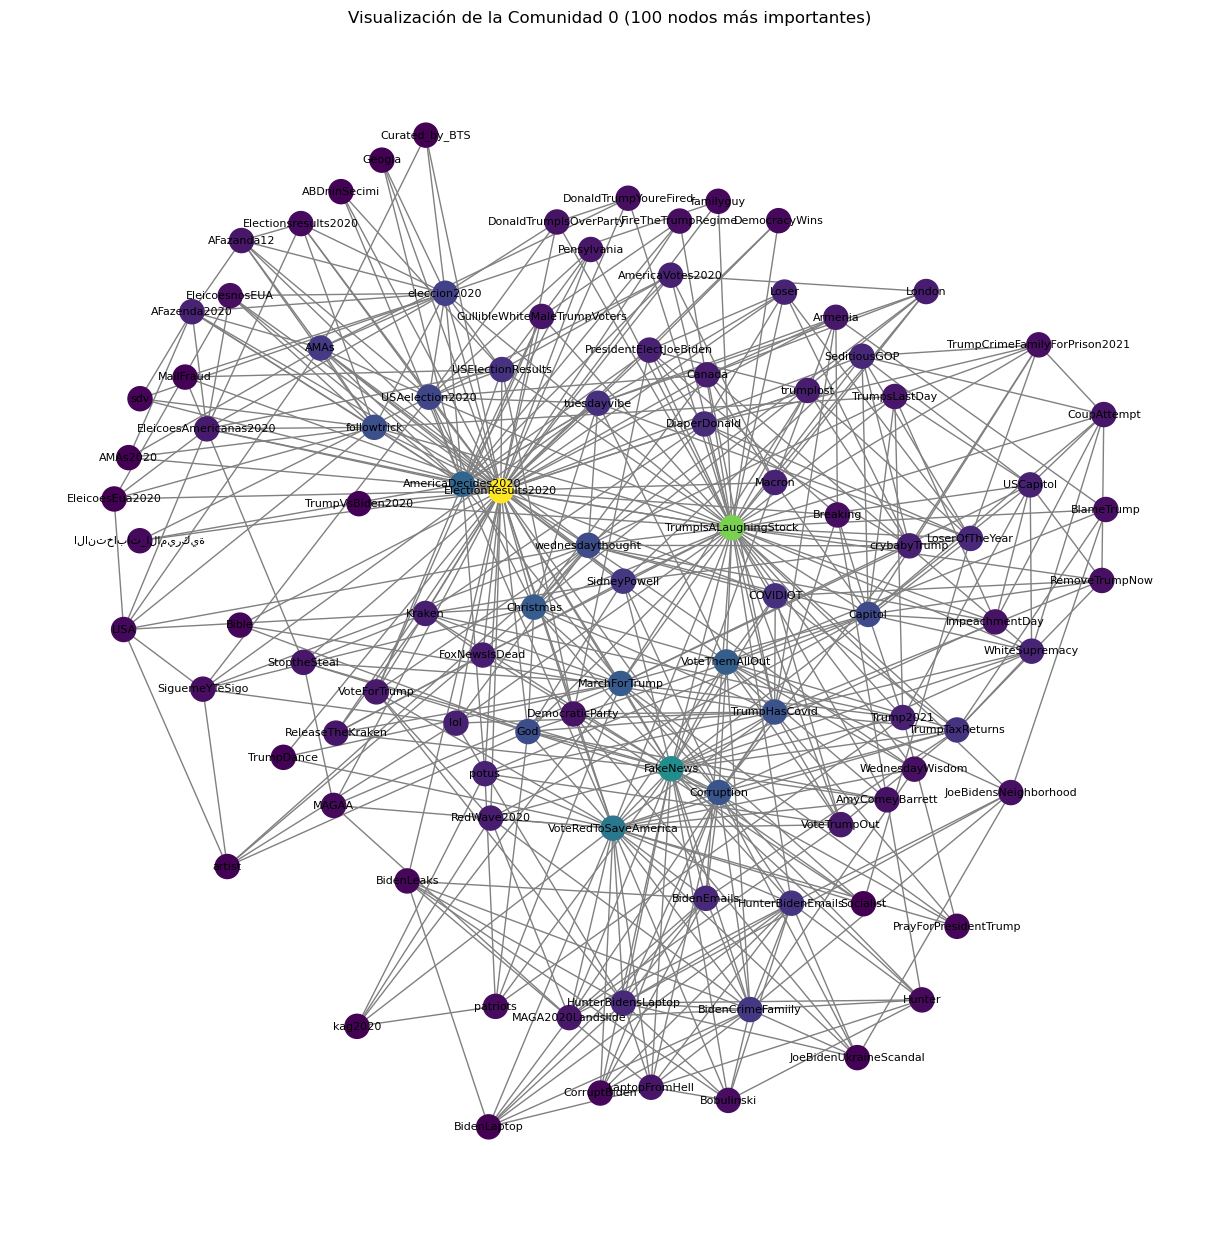

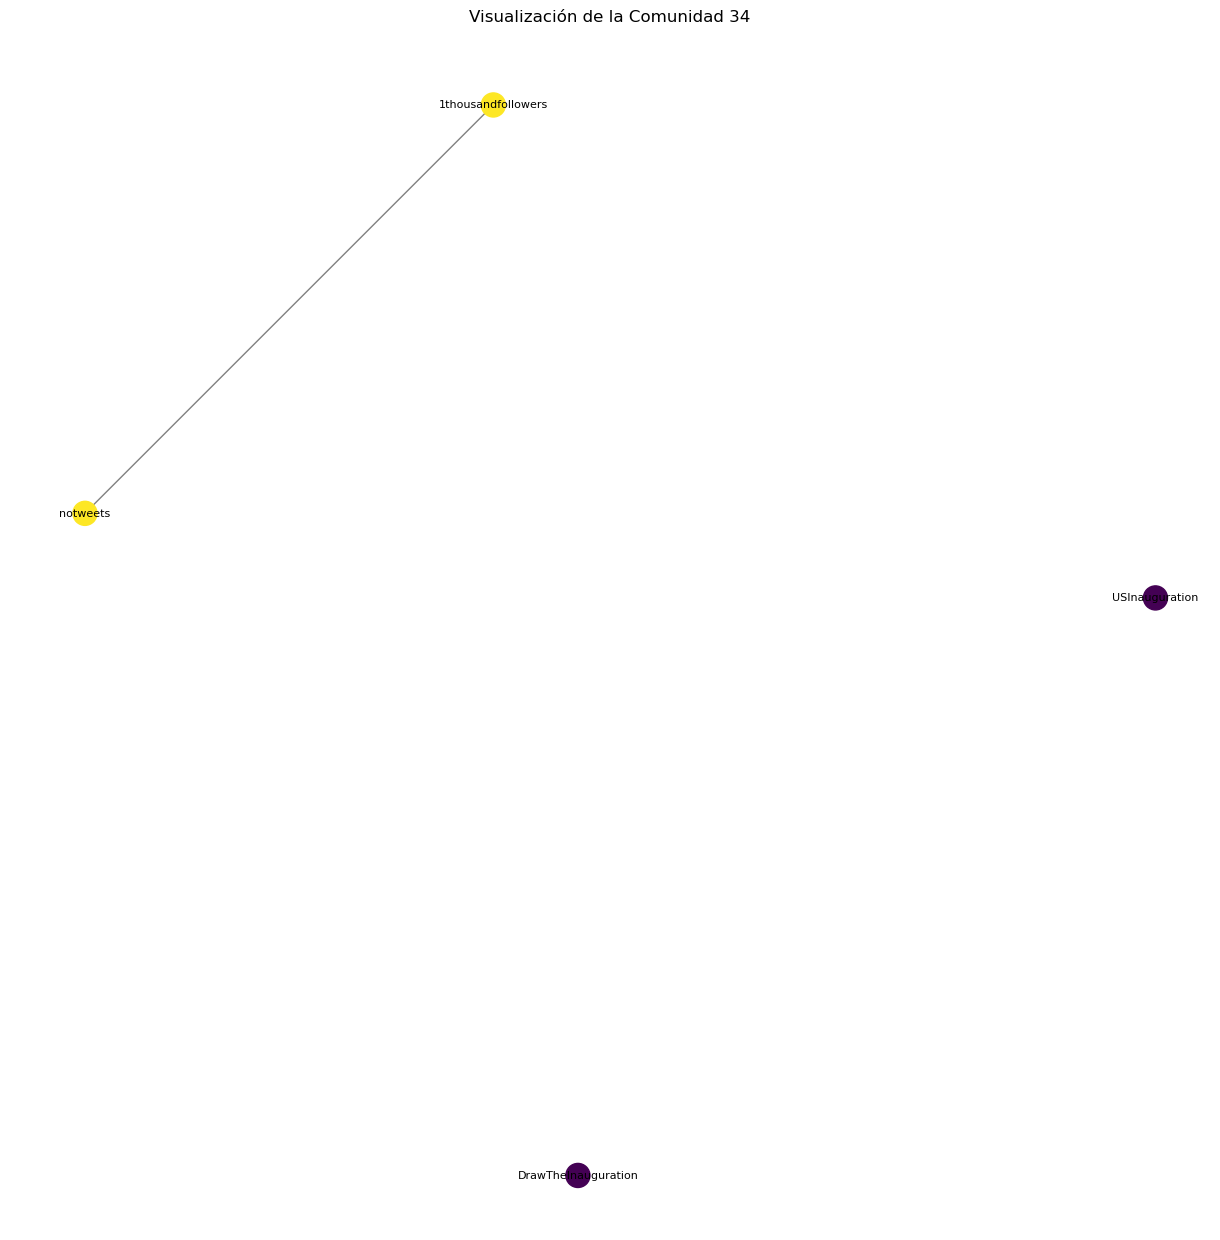

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

for u, v, data in G.edges(data=True):
    if "weight" not in data or not isinstance(data["weight"], (int, float)):
        G[u][v]["weight"] = 1.0

# Seleccionar la comunidad más grande
comunidad_mas_grande = max(range(len(partition)), key=lambda i: len(partition[i]))
print(f"Comunidad más grande: {comunidad_mas_grande} ({len(partition[comunidad_mas_grande])} nodos)")

# Seleccionar la comunidad más pequeña
comunidad_mas_pequena = min(range(len(partition)), key=lambda i: len(partition[i]))
print(f"Comunidad más pequeña: {comunidad_mas_pequena} ({len(partition[comunidad_mas_pequena])} nodos)")

# Obtener nodos de las comunidades más grande y más pequeña
nodos_grande = [list(G.nodes())[i] for i in partition[comunidad_mas_grande]]
nodos_pequena = [list(G.nodes())[i] for i in partition[comunidad_mas_pequena]]

# Crear subgrafos de las comunidades más grande y más pequeña
subgrafo_grande = G.subgraph(nodos_grande)
subgrafo_pequena = G.subgraph(nodos_pequena)

# Calcular una métrica de centralidad (puede ser otra métrica relevante)
centrality_grande = nx.eigenvector_centrality(subgrafo_grande)
centrality_pequena = nx.eigenvector_centrality(subgrafo_pequena)

# Seleccionar los 100 nodos más importantes según la métrica
nodos_importantes_grande = sorted(centrality_grande, key=centrality_grande.get, reverse=True)[:100]
nodos_importantes_pequena = sorted(centrality_pequena, key=centrality_pequena.get, reverse=True)
subgrafo_limitado_grande = subgrafo_grande.subgraph(nodos_importantes_grande)
subgrafo_limitado_pequena = subgrafo_pequena.subgraph(nodos_importantes_pequena)

# Filtrar los valores de centralidad para los nodos seleccionados
centrality_limitada_grande = {nodo: centrality_grande[nodo] for nodo in subgrafo_limitado_grande.nodes}
centrality_limitada_pequena = {nodo: centrality_pequena[nodo] for nodo in subgrafo_limitado_pequena.nodes}

# Dibujar el subgrafo limitado de la comunidad más grande
plt.figure(figsize=(12, 12))
pos_grande = nx.kamada_kawai_layout(subgrafo_limitado_grande)
nx.draw(
    subgrafo_limitado_grande,
    pos_grande,
    with_labels=True,
    node_color=list(centrality_limitada_grande.values()),
    cmap=plt.cm.viridis,
    node_size=300,
    font_size=8,
    edge_color="gray"
)
plt.title(f"Visualización de la Comunidad {comunidad_mas_grande} (100 nodos más importantes)")
plt.show()

# Dibujar el subgrafo limitado de la comunidad más pequeña
plt.figure(figsize=(12, 12))
pos_pequena = nx.kamada_kawai_layout(subgrafo_limitado_pequena)
nx.draw(
    subgrafo_limitado_pequena,
    pos_pequena,
    with_labels=True,
    node_color=list(centrality_limitada_pequena.values()),
    cmap=plt.cm.viridis,
    node_size=300,
    font_size=8,
    edge_color="gray"
)
plt.title(f"Visualización de la Comunidad {comunidad_mas_pequena}")
plt.show()

## Ejercicio 7
Finalmente, describe los contenidos de cada comunidad. ¿Es posible, aunque sea intuitivamente, caracterizar una comunidad en función de sus hashtags más importantes?

Es muy difícil caracterizarlas. Existen muchos hashtags que podrían pertenecer a más de una comunidad, por lo que no existe un patrón fácil de seguir para enterder cada comunidad. Además, tampoco se agrupan en siguiendo los idiomas.

In [26]:
import networkx as nx
import pandas as pd

# Calcular el PageRank en el grafo original
pagerank = nx.pagerank(G, weight="weight")

# Asignar el PageRank como atributo a los nodos del grafo
attributes = {}
for nodo in G.nodes:
    attributes[nodo] = {"pagerank": pagerank[nodo]}
nx.set_node_attributes(G, attributes)

# Añadir las comunidades como atributo en los nodos
for nodo, comunidad in node_to_community.items():
    G.nodes[nodo]["community"] = comunidad

# Mostrar los 5 hashtags más importantes por comunidad
com_ids = set([G.nodes[n]["community"] for n in G.nodes])  # Identificar todas las comunidades
for cid in sorted(com_ids):  # Iterar sobre las comunidades
    print(f"Comunidad {cid}:")
    # Crear un DataFrame con los nodos de la comunidad actual y sus atributos
    centralities = pd.DataFrame(
        [G.nodes[n] for n in G.nodes if G.nodes[n]["community"] == cid],
        index=[n for n in G.nodes if G.nodes[n]["community"] == cid]
    )
    # Ordenar por el PageRank y mostrar los 5 más importantes
    display(centralities.sort_values(by="pagerank", ascending=False).head(5))
    print("==================================")


Comunidad 0:


,pagerank,community
ElectionResults2020,0.001991,0
TrumpIsALaughingStock,0.000962,0
followtrick,0.000903,0
TrumpHasCovid,0.000779,0
Capitol,0.000747,0


Comunidad 1:


,pagerank,community
Biden,0.021589,1
ElectionDay,0.008092,1
USA,0.006690,1
Biden2020,0.006458,1
maga,0.005387,1


Comunidad 2:


,pagerank,community
Michigan,0.001085,2
Covid,0.000826,2
MSNBC2020,0.000716,2
democrats,0.000668,2
TrumpIsACriminal,0.000667,2


Comunidad 3:


,pagerank,community
Trump,0.056138,3
BidenHarris2020,0.019026,3
trump,0.011373,3
VOTE,0.004298,3
JoeBiden,0.004254,3


Comunidad 4:


,pagerank,community
Elections2020,0.009951,4
VoteBlue,0.006210,4
Georgia,0.002241,4
Vote2020,0.001979,4
AmericaFirst,0.001929,4


Comunidad 5:


,pagerank,community
Texas,0.000860,5
AFazenda12,0.000857,5
BidenHarrisLandslide2020,0.000740,5
News,0.000564,5
stopthesteal,0.000563,5


Comunidad 6:


,pagerank,community
election2020,0.002746,6
covid19,0.001356,6
VoteBlueToSaveAmerica,0.001325,6
TRUMP2020ToSaveAmerica,0.001267,6
WashingtonDC,0.001051,6


Comunidad 7:


,pagerank,community
MAGA,0.026434,7
Trump2020,0.017183,7
MAGA2020,0.007612,7
COVID19,0.007120,7
coronavirus,0.003562,7


Comunidad 8:


,pagerank,community
TRUMP2020,0.001158,8
USElection2020,0.000873,8
Elecciones,0.000645,8
ProudBoys,0.000594,8
Resisters,0.000526,8


Comunidad 9:


,pagerank,community
TrumpIsANationalDisgrace,0.001040,9
bidenharis2020,0.000453,9
BIDEN,0.000389,9
kamalaharris,0.000297,9
Inauguration2021,0.000293,9


Comunidad 10:


,pagerank,community
love,0.000479,10
TrumpCovid,0.000478,10
foxnews,0.000433,10
Fraud,0.000315,10
EndSARS,0.000243,10


Comunidad 11:


,pagerank,community
Election2020,0.028263,11
Vote,0.003349,11
joebiden,0.000722,11
Americans,0.000653,11
FourMoreYears,0.000424,11


Comunidad 12:


,pagerank,community
JOEBIDEN2020,0.000208,12
VoteBlueDownTheBallot,0.000146,12
HumanRights,0.000142,12
Salvini,0.000140,12
socialmedia,0.000117,12


Comunidad 13:


,pagerank,community
KAG,0.004305,13
DonaldTrump,0.003559,13
kag,0.000661,13
TrumpTrain,0.000546,13
Beirut,0.000364,13


Comunidad 14:


,pagerank,community
Trending,0.000259,14
ElectionCommandCentre,0.000128,14
拜登,0.000076,14
Communist,0.000062,14
SuperEagles,0.000055,14


Comunidad 15:


,pagerank,community
FridayThoughts,0.000149,15
CristianoRonaldo,0.000041,15
DontGetComplacent,0.000037,15
ziyaselcuk,0.000029,15
MICHIGAN,0.000025,15


Comunidad 16:


,pagerank,community
CIA,0.000180,16
CorruptGOP,0.000091,16
realtalk,0.000084,16
horror,0.000082,16
newmusic,0.000075,16


Comunidad 17:


,pagerank,community
forextrading,0.000056,17
Regeneron,0.000034,17
Maradona,0.000025,17
JustDoIT,0.000022,17
NonEssentialGovernmentEmployee,0.000022,17


Comunidad 18:


,pagerank,community
cia,0.000026,18
queens,0.000012,18
bronx,0.000011,18
Hogwarts,0.000011,18
karenmemes,0.000011,18


Comunidad 19:


,pagerank,community
zorgpremie,0.000012,19
Chr,0.000005,19
Session,0.000005,19
DocNelleTueMani,0.000005,19
Mixing,0.000005,19


Comunidad 20:


,pagerank,community
CREO21,0.000011,20
CapitalRiots,0.000011,20
raggi,0.000010,20
نفط,0.000007,20
8gennaio,0.000007,20


Comunidad 21:


,pagerank,community
AfricanaStudies,0.000007,21
Africana,0.000007,21
Sankofa,0.000007,21
OustDuterte,0.000007,21
TrudeauTreason,0.000006,21


Comunidad 22:


,pagerank,community
Evangelicals,0.000105,22
CrookedKelly,0.000013,22
言論弾圧,0.000011,22
TeamPelosi,0.000007,22
テロリズム,0.000007,22


Comunidad 23:


,pagerank,community
球場で撮った野球じゃない写真選手権,0.000011,23
監察医朝顔,0.000011,23
SixTONESと同じ時代刻もう,0.000010,23
クイズTHE違和感,0.000010,23
なこと,0.000010,23


Comunidad 24:


,pagerank,community
Whatsapp,0.000014,24
BodyPositivePhotography,0.000011,24
activewear,0.000010,24
demcastGA,0.000009,24
GlobalUprise,0.000006,24


Comunidad 25:


,pagerank,community
MAZA,0.000005,25
brain,0.000005,25
Read,0.000004,25
IncompeTrump,0.000004,25
BidenGaffes,0.000004,25


Comunidad 26:


,pagerank,community
NowStreaming,0.000007,26
TrumpNorth,0.000006,26
HeCheated,0.000005,26
RepLaurenBoebert,0.000004,26
OnePlus8T,0.000004,26


Comunidad 27:


,pagerank,community
GArunoff,0.000007,27
VueltaRTVE7N,0.000005,27
8Noviembre,0.000005,27
RunOff,0.000005,27
OnlyLegalVotesCount,0.000004,27


Comunidad 28:


,pagerank,community
spaanse,0.000015,28
March4Trump,0.000011,28
CFR_VIOLATIONS,0.000006,28
chanelrion,0.000005,28
TrumpFriction,0.000005,28


Comunidad 29:


,pagerank,community
Fight4Trump,0.000018,29
spoof,0.000008,29
artlibre,0.000005,29
7Dimanche,0.000005,29
RIPGINIMBI,0.000005,29


Comunidad 30:


,pagerank,community
wrighthabits,0.000009,30
พี่ไม่หล่อลวง,0.000006,30
eTitulo,0.000006,30
CONCEDED,0.000004,30
トランプ大統領逆転大勝利,0.000003,30


Comunidad 31:


,pagerank,community
Fakhrizadeh,0.000012,31
SPYGATE,0.000011,31
ToutVaBien,0.000008,31
9D,0.000004,31
CarQDecal,0.000003,31


Comunidad 32:


,pagerank,community
asels,0.000008,32
akbnk,0.000007,32
sise,0.000007,32
JAPAN,0.000005,32
GirlzTalkZa,0.000003,32


Comunidad 33:


,pagerank,community
フォトコン,0.000013,33
インスタフォト,0.000013,33
コンテスト,0.000013,33
Villarejo,0.000007,33
Impeachbiden,0.000003,33


Comunidad 34:


,pagerank,community
1thousandfollowers,0.000009,34
notweets,0.000009,34
USInauguration,0.000003,34
DrawTheInauguration,0.000003,34


Comunidad 35:


,pagerank,community
BidenBelieves,0.000015,35
transgenre,0.000004,35
lachlanmurdoch,0.000004,35
Moesha,0.000003,35


Comunidad 36:


,pagerank,community
MaskLess,0.000009,36
Stash,0.000009,36
Encouraged,0.000008,36
USEP2020,0.000003,36


Comunidad 37:


,pagerank,community
ufukötesi,0.000005,37
tele1,0.000005,37
DecencyWins,0.000004,37
YouarethetruepresidentoftheUnitedStates,0.000003,37
